In [22]:
import scanpy as sc
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter, defaultdict

In [2]:
FILE = "datasets/10XGenomics/Targeted_SC3v3_Human_Glioblastoma_Neuroscience_filtered_feature_bc_matrix.h5"

In [3]:
adata = sc.read_10x_h5(FILE)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
X = adata.X.todense()

In [5]:
X.shape

(5697, 1186)

In [6]:
def cell(i):
    return np.array(X[i, :]).flatten()

In [7]:
ncells = X.shape[0]
sims = np.zeros((ncells, ncells))

cells = []
for i in tqdm.trange(ncells):
    cells.append(cell(i))

for i in tqdm.trange(ncells):
    for j in range(ncells):
        sims[i][j] = np.sum(np.absolute(cells[i] - cells[j]))

100%|███████████████████████████████████████| 5697/5697 [01:43<00:00, 55.14it/s]


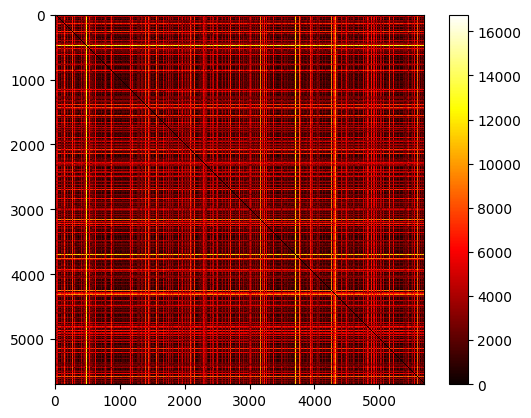

In [8]:
plt.imshow(sims, cmap='hot', interpolation='none')
plt.colorbar()

In [9]:
sims2 = np.zeros((ncells, ncells))

for i in tqdm.trange(ncells):
    for j in range(ncells):
        sims2[i][j] = np.count_nonzero(cells[i] - cells[j])

100%|███████████████████████████████████████| 5697/5697 [01:38<00:00, 57.60it/s]


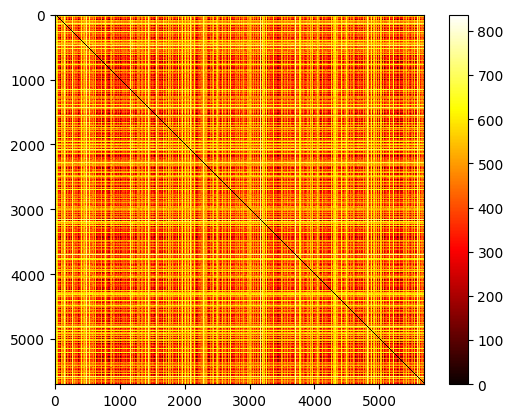

In [10]:
plt.imshow(sims2, cmap='hot', interpolation='none')
plt.colorbar()

{'whiskers': [<matplotlib.lines.Line2D at 0x32ed11670>,
 'caps': [<matplotlib.lines.Line2D at 0x32ed99520>,
 'boxes': [<matplotlib.lines.Line2D at 0x32ed11880>],
 'medians': [<matplotlib.lines.Line2D at 0x32ed99a60>],
 'fliers': [<matplotlib.lines.Line2D at 0x32ed99cd0>],
 'means': []}

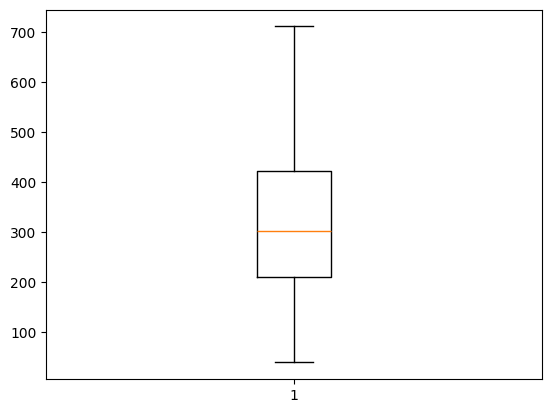

In [11]:
x = [min([i for i in j if i != 0]) for j in sims2]
plt.boxplot(x)

{'whiskers': [<matplotlib.lines.Line2D at 0x32ee174a0>,
 'caps': [<matplotlib.lines.Line2D at 0x32ee17920>,
 'boxes': [<matplotlib.lines.Line2D at 0x32ee17200>],
 'medians': [<matplotlib.lines.Line2D at 0x32ee17ef0>],
 'fliers': [<matplotlib.lines.Line2D at 0x32ee441d0>],
 'means': []}

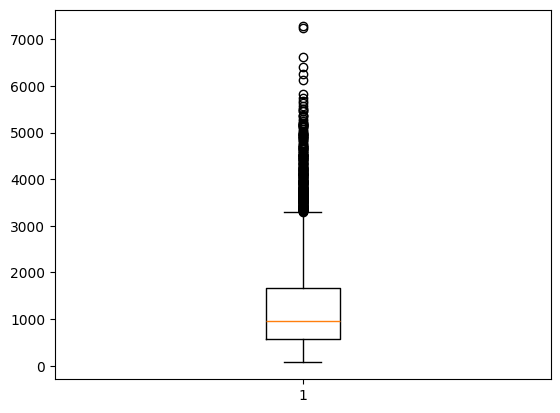

In [12]:
x = [min([i for i in j if i != 0]) for j in sims]
plt.boxplot(x)

{'whiskers': [<matplotlib.lines.Line2D at 0x32ed35e80>,
 'caps': [<matplotlib.lines.Line2D at 0x32ed362d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x32ed35c70>],
 'medians': [<matplotlib.lines.Line2D at 0x32ed36870>],
 'fliers': [<matplotlib.lines.Line2D at 0x32ed36b40>],
 'means': []}

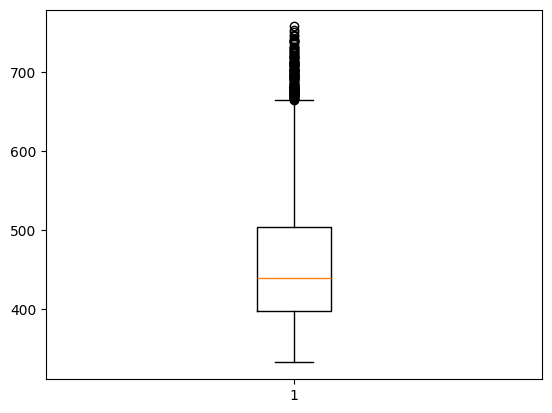

In [13]:
x = [np.average([i for i in j if i != 0]) for j in sims2]
plt.boxplot(x)

In [14]:
max_avg_sim = np.quantile(x, 0.75)

In [41]:
good_cells = []
weird_cells = []
for i, c in enumerate(cells):
    if x[i] < max_avg_sim:
        good_cells.append(c)
    else:
        weird_cells.append(c)

In [16]:
len(good_cells)

4272

In [17]:
kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(np.array(good_cells))

In [18]:
kmeans.labels_

array([0, 0, 9, ..., 7, 7, 7], dtype=int32)

In [19]:
kmeans.cluster_centers_[0]

array([1.2278345e+00, 1.6120340e-03, 2.2095647e+00, ..., 2.3052104e-01,
       1.3648583e-01, 0.0000000e+00], dtype=float32)

In [20]:
len(good_cells[1]) - sum(1 for a, b in zip(good_cells[1], kmeans.cluster_centers_[0]) if abs(a - b) < 8)

9

In [24]:
for i, cell in enumerate(good_cells):
    cluster = kmeans.cluster_centers_[kmeans.labels_[i]]
    k = [int(a - b) for a, b in zip(cell, cluster)]
    print(Counter(k))

Counter({0: 1051, -1: 64, -2: 26, -4: 9, -6: 7, -3: 7, 1: 6, -7: 4, -8: 3, 2: 2, -12: 2, -5: 2, -9: 2, -16: 1})
Counter({0: 1047, -1: 62, -2: 23, -3: 12, 1: 10, -5: 8, -6: 6, -4: 4, -8: 3, -12: 2, -7: 2, 5: 2, 33: 1, 16: 1, 2: 1, -15: 1, -10: 1})
Counter({0: 922, 1: 74, 2: 42, -1: 41, 3: 16, 4: 15, -3: 10, -2: 9, 5: 6, -7: 4, 15: 3, 7: 3, -5: 3, -4: 3, -6: 3, 8: 3, -17: 2, -12: 2, 13: 2, -15: 1, -9: 1, 89: 1, 9: 1, -14: 1, 16: 1, 12: 1, 30: 1, 67: 1, 6: 1, 21: 1, 20: 1, 496: 1, 42: 1, -18: 1, 14: 1, -13: 1, 32: 1, 139: 1, 39: 1, -139: 1, 27: 1, 11: 1})
Counter({0: 1020, 1: 54, -1: 35, 2: 27, -2: 8, 3: 8, 4: 6, 6: 4, 5: 3, -3: 3, -4: 2, -7: 2, 14: 1, -33: 1, 21: 1, 7: 1, -9: 1, -45: 1, 45: 1, 12: 1, 60: 1, -17: 1, 18: 1, 8: 1, 56: 1, -6: 1})
Counter({0: 1018, 1: 47, -1: 35, 2: 18, 3: 13, -2: 13, 5: 6, 4: 5, -4: 3, 7: 3, -3: 3, 20: 2, -6: 2, -16: 2, 6: 2, 9: 2, -37: 1, -20: 1, -10: 1, 55: 1, 25: 1, -8: 1, 12: 1, -28: 1, 8: 1, -5: 1, 28: 1, 13: 1})
Counter({0: 1036, 1: 43, -1: 31, 2: 19, 

In [46]:
c = Counter(np.array(cells).flatten())

In [51]:
del c[0]
[c[j] for j in range(1, 483)]

[742869,
 332837,
 183193,
 114213,
 77401,
 55838,
 42245,
 33373,
 27063,
 21912,
 18233,
 15907,
 13561,
 11765,
 10384,
 9064,
 8155,
 7358,
 6762,
 6103,
 5595,
 5033,
 4681,
 4379,
 3995,
 3794,
 3497,
 3241,
 3118,
 2922,
 2608,
 2517,
 2238,
 2142,
 2072,
 1941,
 1909,
 1748,
 1658,
 1619,
 1460,
 1424,
 1442,
 1262,
 1219,
 1234,
 1131,
 1051,
 1009,
 1004,
 1022,
 877,
 875,
 882,
 856,
 852,
 794,
 718,
 736,
 709,
 652,
 622,
 623,
 543,
 574,
 528,
 547,
 529,
 543,
 485,
 481,
 458,
 449,
 431,
 417,
 427,
 390,
 392,
 389,
 382,
 365,
 365,
 360,
 337,
 311,
 319,
 285,
 298,
 296,
 271,
 284,
 256,
 268,
 263,
 281,
 252,
 246,
 253,
 236,
 245,
 205,
 222,
 223,
 228,
 185,
 188,
 186,
 174,
 200,
 190,
 166,
 171,
 169,
 193,
 166,
 164,
 152,
 174,
 148,
 161,
 146,
 167,
 153,
 148,
 142,
 123,
 149,
 138,
 121,
 143,
 132,
 123,
 101,
 120,
 105,
 111,
 120,
 107,
 103,
 118,
 90,
 113,
 106,
 106,
 105,
 99,
 118,
 94,
 89,
 75,
 84,
 88,
 77,
 85,
 86,
 95,
 80,


In [56]:
[(j, c[j]) for j in range(483, 2551) if j in c]

[(484, 2),
 (485, 2),
 (486, 3),
 (487, 4),
 (489, 3),
 (490, 4),
 (492, 3),
 (493, 1),
 (494, 3),
 (495, 4),
 (496, 4),
 (497, 4),
 (498, 2),
 (499, 3),
 (500, 3),
 (501, 4),
 (502, 3),
 (503, 6),
 (504, 1),
 (505, 4),
 (506, 2),
 (507, 3),
 (509, 5),
 (510, 1),
 (511, 5),
 (512, 1),
 (513, 3),
 (515, 2),
 (516, 5),
 (517, 4),
 (518, 4),
 (519, 3),
 (520, 4),
 (521, 2),
 (522, 6),
 (523, 5),
 (524, 3),
 (525, 2),
 (526, 5),
 (527, 2),
 (528, 3),
 (529, 7),
 (530, 1),
 (531, 4),
 (532, 2),
 (533, 5),
 (535, 3),
 (536, 2),
 (538, 7),
 (539, 4),
 (540, 3),
 (541, 3),
 (542, 5),
 (543, 2),
 (544, 3),
 (546, 6),
 (547, 2),
 (548, 8),
 (549, 4),
 (550, 2),
 (551, 1),
 (552, 1),
 (553, 1),
 (554, 3),
 (555, 2),
 (557, 3),
 (558, 3),
 (559, 4),
 (560, 1),
 (561, 4),
 (562, 2),
 (563, 4),
 (564, 1),
 (565, 1),
 (566, 2),
 (567, 4),
 (568, 1),
 (569, 2),
 (570, 1),
 (571, 1),
 (572, 2),
 (573, 5),
 (574, 3),
 (575, 3),
 (576, 4),
 (577, 1),
 (578, 2),
 (579, 2),
 (580, 4),
 (581, 1),
 (582, 1),

In [40]:
sum(c.values())

1850701

In [60]:
max(c)

2551.0

In [44]:
(5697 * 1186)

6756642

In [71]:
B = lambda i: len(bin(i)) - 2
N = sum(c.values())
O = c[1]

i = 1
while i in c:
    i += 1
K = i - 1

T1 = 0
T2 = []
M = int(max(c))
for j in range(i, M):
    if j not in c:
        continue
    T1 += 1
    T2.append(c[j])

T = T1
S = max(T2)

N * B(N) + K * B(O) + T * (B(M) + B(S))

38881689